# Imports

In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error

In [2]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [3]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

# Helper Functions

In [4]:
def create_trip_duration_column(df):
    # trip duration
    df["trip_duration"] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    # convert trip_duration to minutes
    df["trip_duration"] = df["trip_duration"].apply(lambda x: x.total_seconds()/60)

    return df

def create_pickup_plus_dropoff_id(df):
    df["PU_DO_ID"] = df["PULocationID"].astype(str) + "_" + df["DOLocationID"].astype(str)

    return df

def filter_duration(df):
    df = df[(df.trip_duration >= 1) & (df.trip_duration <= 60)]

    return df

def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        
        booster = xgb.train(
            params = params,
            dtrain = train_data,
            num_boost_round=1000,
            evals=[(val_data, "validation")],
            early_stopping_rounds = 50
        )

        y_pred = booster.predict(val_data)
        rmse = mean_squared_error(y_val, y_pred, squared = False)
        mlflow.log_metric("rmse", rmse)
    
    return {"loss": rmse, "status": STATUS_OK}

# Load Data

In [5]:
df_train = pd.read_parquet("../data/green_tripdata_2021-01.parquet")
df_val = pd.read_parquet("../data/green_tripdata_2021-02.parquet")

# Feature Engineering

In [6]:
df_train = create_trip_duration_column(df_train)
df_val = create_trip_duration_column(df_val)

df_train = create_pickup_plus_dropoff_id(df_train)
df_val = create_pickup_plus_dropoff_id(df_val)

# Univariate Analysis

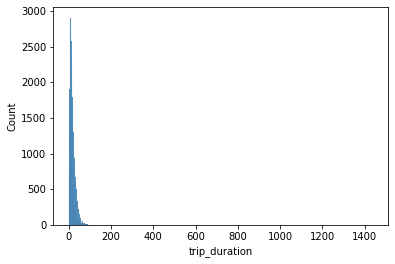

In [7]:
# distribution of trip_duration
sns.histplot(df_train, x = "trip_duration");

In [8]:
df_train.trip_duration.describe()

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
25%          8.000000
50%         13.883333
75%         23.000000
max       1439.600000
Name: trip_duration, dtype: float64

In [9]:
# due to some strange trip durations and to filter some data, lets filter based on trip_duration
df_train = filter_duration(df_train)
df_val = filter_duration(df_val)

# Select Features

In [10]:
# select only some features for the example
categorical_features = ["PU_DO_ID"]
numerical_features = ["trip_distance"]

# Prep Features

In [11]:
# tranform the categorical features with one hot encoding
# first we transform the categorial features in str type
df_train[categorical_features] = df_train[categorical_features].astype(str)
# then we transform the df into a matrix using DictVectorizer, 
# which does the OHE with cat features
train_dicts = df_train[categorical_features + numerical_features].to_dict(orient="records")
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical_features + numerical_features].to_dict(orient="records")
X_val = dv.transform(val_dicts)

In [12]:
y_train = df_train.trip_duration.values
y_val = df_val.trip_duration.values

# Train Model

## XGBoost with HyperOpt

In [13]:
train_data = xgb.DMatrix(X_train, label = y_train)
val_data = xgb.DMatrix(X_val, label = y_val)

In [16]:
search_space = {
    "max_depth": scope.int(hp.quniform("max_depth", 4, 100, 1)),
    "learning_rate": hp.loguniform("learning_rate", -3, 0),
    "reg_alpha": hp.loguniform("reg_alpha", -5, -1),
    "reg_lambda": hp.loguniform("reg_lambda", -6, -1),
    "min_child_weight": hp.loguniform("min_child_weight", -1, 3),
    "objective": "reg:linear",
    "seed": 42
}

best_result = fmin(
    fn = objective,
    space = search_space,
    algo = tpe.suggest,
    max_evals = 50,
    trials = Trials()
)

[02:07:10] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:19.42377                          
[1]	validation-rmse:17.84882                          
[2]	validation-rmse:16.44893                          
[3]	validation-rmse:15.20776                          
[4]	validation-rmse:14.11034                          
[5]	validation-rmse:13.14242                          
[6]	validation-rmse:12.28986                          
[7]	validation-rmse:11.54238                          
[8]	validation-rmse:10.88933                          
[9]	validation-rmse:10.31904                          
[10]	validation-rmse:9.82289                          
[11]	validation-rmse:9.39246                          
[12]	validation-rmse:9.02074                          
[13]	validation-rmse:8.70009                          
[14]	validation-rmse:8.42407                          
[15]	validation-rmse:8.18764                          
[

In [14]:
best_params = {
    "learning_rate": 0.3658500268351324,
    "max_depth": 30,
    "min_child_weight": 1.6787939344371205,
    "objective": "reg:linear",
    "reg_alpha": 0.1247872970730739,
    "reg_lambda": 0.08527574907898512,
    "seed": 42
}

mlflow.xgboost.autolog()
mlflow.set_tag("model", "xgboost")
mlflow.set_tag("version", "best_model")

booster = xgb.train(
    params = best_params,
    dtrain = train_data,
    num_boost_round=1000,
    evals=[(val_data, "validation")],
    early_stopping_rounds = 50
)

[11:21:38] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:14.78516
[1]	validation-rmse:11.03374
[2]	validation-rmse:8.93164
[3]	validation-rmse:7.80582
[4]	validation-rmse:7.21628
[5]	validation-rmse:6.91130
[6]	validation-rmse:6.74205
[7]	validation-rmse:6.64844
[8]	validation-rmse:6.59072
[9]	validation-rmse:6.55568
[10]	validation-rmse:6.53055
[11]	validation-rmse:6.51971
[12]	validation-rmse:6.51295
[13]	validation-rmse:6.50662
[14]	validation-rmse:6.50161
[15]	validation-rmse:6.49527
[16]	validation-rmse:6.48796
[17]	validation-rmse:6.48473
[18]	validation-rmse:6.48167
[19]	validation-rmse:6.47817
[20]	validation-rmse:6.47586
[21]	validation-rmse:6.47339
[22]	validation-rmse:6.46906
[23]	validation-rmse:6.46627
[24]	validation-rmse:6.46318
[25]	validation-rmse:6.45970
[26]	validation-rmse:6.45655
[27]	validation-rmse:6.45316
[28]	validation-rmse:6.45083
[29]	validation-rmse:6.44913
[30]	validation-rms

2022/05/29 11:23:01 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.


In [17]:
mlflow.end_run()

In [15]:
mlflow.xgboost.autolog(disable = True)

In [20]:
with mlflow.start_run():
    best_params = {
        "learning_rate": 0.3658500268351324,
        "max_depth": 30,
        "min_child_weight": 1.6787939344371205,
        "objective": "reg:linear",
        "reg_alpha": 0.1247872970730739,
        "reg_lambda": 0.08527574907898512,
        "seed": 42
    }

    mlflow.log_params(best_params)
    mlflow.set_tag("model", "xgboost")
    mlflow.set_tag("version", "log_model")

    booster = xgb.train(
        params = best_params,
        dtrain = train_data,
        num_boost_round=1000,
        evals=[(val_data, "validation")],
        early_stopping_rounds = 50
    )

    y_pred_val = booster.predict(val_data)
    valid_rmse = mean_squared_error(y_val, y_pred_val, squared = False)

    mlflow.log_metric("valid_rmse", valid_rmse)
    print(f"Validation RMSE: {valid_rmse}")

    with open("../models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)

    mlflow.log_artifact("../models/preprocessor.b", artifact_path = "preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path = "models_mlflow")

[11:47:35] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:14.78516
[1]	validation-rmse:11.03374
[2]	validation-rmse:8.93164
[3]	validation-rmse:7.80582
[4]	validation-rmse:7.21628
[5]	validation-rmse:6.91130
[6]	validation-rmse:6.74205
[7]	validation-rmse:6.64844
[8]	validation-rmse:6.59072
[9]	validation-rmse:6.55568
[10]	validation-rmse:6.53055
[11]	validation-rmse:6.51971
[12]	validation-rmse:6.51295
[13]	validation-rmse:6.50662
[14]	validation-rmse:6.50161
[15]	validation-rmse:6.49527
[16]	validation-rmse:6.48796
[17]	validation-rmse:6.48473
[18]	validation-rmse:6.48167
[19]	validation-rmse:6.47817
[20]	validation-rmse:6.47586
[21]	validation-rmse:6.47339
[22]	validation-rmse:6.46906
[23]	validation-rmse:6.46627
[24]	validation-rmse:6.46318
[25]	validation-rmse:6.45970
[26]	validation-rmse:6.45655
[27]	validation-rmse:6.45316
[28]	validation-rmse:6.45083
[29]	validation-rmse:6.44913
[30]	validation-rms

In [21]:
logged_model = 'runs:/a8b2fac9f2264b4e912b609e5a3ae7c2/models_mlflow'
loaded_model = mlflow.pyfunc.load_model(logged_model)
xgboost_model = mlflow.xgboost.load_model(logged_model)

[11:50:48] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[11:50:48] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [22]:
y_pred = xgboost_model.predict(val_data)

## Linear Regression

In [12]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_train)

/home/olini/Projects/mlops-zoomcamp/mlops-zoomcamp/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/olini/Projects/mlops-zoomcamp/mlops-zoomcamp/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


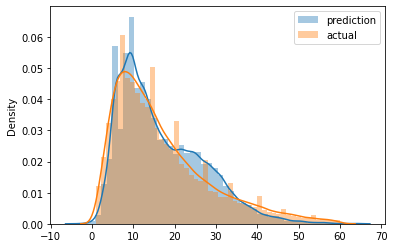

In [13]:
sns.distplot(y_pred, label = "prediction")
sns.distplot(y_train, label = "actual")

plt.legend()

In [14]:
print(f"Training RMSE: {mean_squared_error(y_train, y_pred, squared = False)}")

Training RMSE: 5.699564118202546


In [15]:
y_pred_val = lr.predict(X_val)
print(f"Validation RMSE: {mean_squared_error(y_val, y_pred_val, squared = False)}")

Validation RMSE: 7.758715199477344


## Lasso Regression

In [17]:
with mlflow.start_run():
    mlflow.set_tag("developer", "olini")
    mlflow.log_param("train_data_path", "../data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid_data_path", "../data/green_tripdata_2021-02.parquet")

    alpha = 0.01
    mlflow.log_param("alpha", alpha)

    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)

    y_pred = lasso.predict(X_train)
    train_rmse = mean_squared_error(y_train, y_pred, squared = False)

    mlflow.log_metric("train_rmse", train_rmse)
    print(f"Training RMSE: {train_rmse}")

    y_pred_val = lasso.predict(X_val)
    valid_rmse = mean_squared_error(y_val, y_pred_val, squared = False)

    mlflow.log_metric("valid_rmse", valid_rmse)
    print(f"Validation RMSE: {valid_rmse}")

    mlflow.log_artifact(local_path = "../models/lin_reg.bin", artifact_path = "models_pickle/")

Training RMSE: 10.550479040582232
Validation RMSE: 11.167275941179728


## Ridge Regression

In [163]:
ridge = Ridge()
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_train)

print(f"Training RMSE: {mean_squared_error(y_train, y_pred, squared = False)}")

y_pred_val = ridge.predict(X_val)
print(f"Validation RMSE: {mean_squared_error(y_val, y_pred_val, squared = False)}")

Training RMSE: 10.712682923244786
Validation RMSE: 11.34260394325033


## Save best model

In [166]:
with open("models/lin_reg.bin", "wb") as file:
    pickle.dump((dv, lr), file)